# Bayesian Inference: Prior and Posterior

In [1]:
# Import some helper functions (please ignore this!)
from utils import *

**Context:** If there's one thing we learned from the chapter on model selection and evaluation is that we should not blindly trust our models. Models are complicated and require a robust and diverse toolkit for responsible evaluation in their intended context. For safety-critical applications of ML, like the ones from the IHH, we must take additional precautions to ensure responsible use. We therefore adopt the following philosophy:
1. **Finite information $\rightarrow$ uncertainty.** We're often asked to make decisions without all the information necessary for certainty. We ask the same of our models: given a finite data set, we ask models to make predictions for patients they have never encountered. Therefore, for responsible use in safety-critical contexts, our models must have some way of quantifying the limits of their "knowledge."
2. **Not making choices $\rightarrow$ a choice will be made for you.** If we avoid making explicit choices in the design of our model, a choice will still be made for us---and it might not be the choice we want. For example, without explicitly choosing what's important to us, we might get a model with the highest accuracy for a task for which minimizing false negatives is most important. *It's therefore better to make your choices explicitly.*

**Challenge:** To satisfy our new modeling philosophy, we need (1) a way to quantify uncertainty, and (2) a way to understand how uncertainty depends on our modeling choices. How can we do that with the tools we have? As we show here, we can't. We will then introduce a new way of fitting ML models called Bayesian inference.

**Outline:** 
* Motivate the need for uncertainty
* Introduce a new modeling paradigm based on Bayes' rule
* Provide intuition for this modeling paradigm
* Implement this modeling paradigm in `NumPyro` 

**Data:** To help make the concepts concrete, we'll return to our regression data, in which we wanted to predict telekinetic ability from age. Let's load the data in:

In [1]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CTR-CGLF-regression-augmented.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Age,Glow,Telekinetic-Ability
Patient ID,,,
90,30.607729,0.604085,-0.020933
254,38.531357,0.613645,-0.070165
283,21.879414,0.829212,0.140791
445,2.949004,0.981120,0.261027
461,30.237446,0.688329,-0.027250
15,29.562483,0.796853,-0.033701
316,15.283975,0.839546,0.344510
489,2.688488,0.929422,0.268031
159,4.129371,0.893813,0.422464


## Why We Need Uncertainty

**The MLE is Over-Confident.** In safety-critical contexts, like those from the IHH, it's important that our ML models don't just fit the observed data well; they should also communicate with us the limits of their "knowledge." Let's illustrate what we mean. Consider the regression data below:

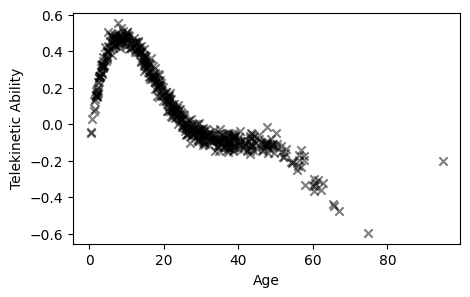

In [7]:
plt.figure(figsize=(5, 3))
plt.scatter(data['Age'], data['Telekinetic-Ability'], color='black', alpha=0.5, marker='x')
plt.xlabel('Age')
plt.ylabel('Telekinetic Ability')
plt.show()

If we were to make a prediction for a patient of age 85, what should the model do? The model wasn't trained on any such patients. Does the trend keep going down with age? Does it go up after age 80? It's impossible for us to know because we haven't observed data about such patients. In cases such as these, it's important that our model alert us about its uncertainty. 

Especially in recent years, there has been more and more research dedicated to developing models that can reliably quantify uncertainty. As an example, a recent paper evaluated how confident different deep learning models are on a medical imaging task. In the paper, the authors evaluated models for predicting whether patients had COVID or not from X-ray scans. Here's what they found:


```{figure} _static/figs/cats-vs-covid.png
---
width: 100%
name: cats-vs-covid
align: center
---

ML models can be over-confident about wrong predictions. Figure adapted from [this paper](https://www.semanticscholar.org/paper/Can-Your-AI-Differentiate-Cats-from-Covid-19-Sample-Mallick-Dwivedi/c100c33afbb2efa5197f7d6042022e1227c5e298).
```
As you can see from the figure, the model makes predictions that aren't only incorrect, *but also overconfident*. And it does this for inputs (like the cat) for which it should really just communicate "I don't know." 

How can a model know when it "doesn't know"? When there are many possible models that fit the data reasonably well, but behave differently away from the data (i.e. on previously unseen inputs, like the cat). Given these options, perhaps we could devise some algorithm to select the one we would like to use on our downstream task, or find some way to *combine* them. Unfortunately, the learning algorithm we've use so far---the MLE---doesn't provide us with a way to do this. The MLE gives a *single* model. 

**Ensembling.** One way to solve this issue is by relying on the imperfections of the optimizer. Remember that, especially for more expressive models, optimization tends to get stuck in local optima. What if we were to collect an *ensemble* of models, all fit with the MLE to data, but each optimized from a different random initialization? Because each model would get stuck in a different local optima, each *might* behave differently than the others away from the data. What's nice about this approach is that it's easy to implement: we already have all the tools we need! Let's see what ensembling a neural network regression model looks like:

TODO figure of NN ensemble on above data

While effective in practice, ensembling also has one big problem when it comes to safety-critical contexts. It makes implicit assumptions that are difficult to understand. Specifically, we relied on the imperfections of our black-box optimizer to find us a diverse set of models. What kind of models will the optimizer give us, however? Do these models have an *inductive bias* that are appropriate for our task? 

The need for explicit assumptions motivates us to find an alternative way of fitting our models to day, leading us to the *Bayesian approach*. 

## What is Uncertainty?

To design a system that captures uncertainty, we first need to know what it means. To do this, let's think about the uncertainty we encounter in everyday scenarios. Maybe these will help us formalize uncertainty mathematically.

**Total Certainty.** When you have lots of data, and you have a *mechanistic* understanding of the system, you have certainty. By mechanistic understand, we mean that you can characterize the system mathematically (e.g. you can predict how quickly an object will fall because you have an equation for gravity).
> Example: You're asked to predict whether the sun will rise tomorrow. Of course, you know the sun will rise tomorrow, and you're absolutely certain about it (if you have reason to believe the sun will not rise tomorrow, please do let the teaching staff know so they can head to the course bunker). So what makes you sure the sun will rise tomorrow? There are two reasons you will likely think about. (1) You have an abundance of observational data---the sun has risen every day of your life. (2) You have a model (or inductive bias)---you know that day and night are created by the earth's rotation around its axis. Because you understand the mechanical properties of the system, you know that certain predictions just don't make sense---like the sun can't rise twice in the span of 24 hours.

**Aleatoric Uncertainty.** When you have lots of data from a *noisy* system, you can be certain about the probability of an outcome, but not about the actual outcome. As an example, having observed 100 flips of a fair coin, you can say with fair certainty that the coin will land heads 50\% of the time. But you will never be able to predict whether the next flip will be heads with any greater accuracy. We call this type of uncertainty, *aleatoric uncertainty*. This is uncertainty that's due to the inherent stochasticity in the system. 
> You're asked to predict whether it will rain at Wellesley next week. Having lived in New England for a little while, you scoff at the possibility of getting this prediction correct. New England weather is notoriously unpredictable. So what makes you uncertain about our prediction? You have an abundance of experiential data suggesting that weather is difficult to predict (how many times have you stood outside in the rain, while your phone's weather app says it's sunny?). As a result, you're certain we can't make a good prediction.

All models we've worked with so far quantify aleatoric uncertainty. For example, in our regression and classification models, our observation error captures aleatoric uncertainty.  

**Epistemic Uncertainty.** When you don't have enough data, and you also don't have a mechanistic understanding of the system, you have epistemic uncertainty. 
> You're colleague for the IHH is getting married on Venus next week. Your friend, who is also attending the wedding, asked you to predict the weather on Venus next week (so you can choose your outfit). Having forgotten all of your astrophysics knowledge (or having never learned it), you actually don't know what the weather on Venus is like in general. As a result, what makes you uncertain is: (1) a lack of observations or experiential knowledge, and (2) a model (or domain knowledge) about Venus's climate.

None of our models so far have been able to capture epistemic uncertainty. In the regression case, epistemic uncertainty would be uncertainty over the *parameters* of the model. Epistemic uncertainty indicates that many potential models could explain the observed data, but we don't know which one is the "right" one. We can reduce our uncertainty by observing more data.

**Conclusion.** We need some way of capturing epistemic uncertainty. To do this, we'll next introduce a different way of fitting models, called *Bayesian inference*. 

## The Bayesian Modeling Paradigm

**Capturing Epistemic Uncertainty.** So let's go back to the drawing board and rethink how we've been fitting models this whole time. So far, our approach has been finding the *single* model that maximizes the probability of our observed data: $\theta^\text{MLE} = \log p(\mathcal{D}; \theta)$. But isn't what we're actually interested is the *distribution* of models given the data, $p(\theta | \mathcal{D})$? In other words, conditioned on the data we've observed so far, we want to know which models (represented by their parameters, $\theta$) are likely to fit the data well. In this new paradigm, we hope that:
1. $p(\theta | \mathcal{D})$ will capture a diversity of models with different inductive biases.
2. We can make our assumptions clear, and we can specify what type of inductive biases are appropriate for our task.

And assuming we could compute this distribution, $p(\theta | \mathcal{D})$, how would we actually use it for fitting a model? The process goes something like this:
1. **Prior:** Prior to having observed data, we express our beliefs about possible sets of parameters, $\theta$. Our beliefs don't have to be correct, just reasonable. We then encode our beliefs into a distribution, $p_\theta(\cdot)$, called the "prior."  For example, we scientifically believe that as age increases, glow decreases. As such, we force the slope to be negative by setting $p_\theta(\cdot)$ to be a Normal distribution centered at some negative number. 
2. **Likelihood:** Having observed data, we can score how well any set of parameters, $\theta$, from the prior fits the data by evaluating $p(\mathcal{D} | \theta)$, the joint data likelihood. This distribution is the *very same* distribution we've worked with in all previous chapters.
3. **Posterior Update:** Post observing data, we *update* our beliefs about $\theta$. We do this by computing $p(\theta | \mathcal{D})$. Observing data will help us reduce the initial uncertainty from the prior, honing in on a set of parameters that could explain the data well. As we show in a bit, this posterior update will depend on both the prior and the likelihood distributions. 

**Bayesian Models.** By having a prior distribution $\theta$ to encode our beliefs, we now treat $\theta$ as a *random variable*. This means that our generative process will now include an additional line, in which we sample $\theta$ from the prior. For example, for Bayesian regression, our generative process is:
\begin{align}
\theta &\sim p_\theta(\cdot) \quad (\text{prior}) \\
y_n | x_n, \theta &\sim p_{Y | X}(\cdot | x_n, \theta) = \mathcal{N}(\mu(x_n; \theta), \sigma^2) \quad (\text{likelihood}) \\
\end{align}

We can similarly depict our Bayesian model using a directed graphical model as follows:
<div class="canva-centered-embedding">
  <div class="canva-iframe-container">
    <iframe loading="lazy" class="canva-iframe" src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGLCabxKck&#x2F;QEOGc0tkynDEzLYyuE3z9w&#x2F;view?embed">
    </iframe>
  </div>
</div>

As you can see, the difference between the depiction of the non-Bayesian and the Bayesian regression is that $\theta$ is in a circle, indicating its a random variable. Next, the circle is *white* (not filled in), indicating that $\theta$ is not observed. Our goal will be to infer it given the data. 

Before defining $p(\theta | \mathcal{D})$, let's walk through an example to show you what this process looks like.

**Illustration: Bayesian Regression.** Let's see what the Bayesian modeling paradigm looks like for regression, visually. We'll use the generative process from above, setting $\sigma$ as a constant (so we can ignore it). We've picked an expressive function, $\mu(x_n; \theta)$, that will be fun to visualize---its details aren't important. 

Given our generative process, our goal is to sample the posterior,
\begin{align}
p(\theta | \mathcal{D}) &= p(\theta | x_1, \dots, x_N, y_1, \dots, y_n).
\end{align}
For intuition, we can visualize posterior samples $\theta \sim p(\theta | \mathcal{D})$ by plotting the *functions* they represent, $\mu(x_n; \theta)$. The plot below shows samples from the posterior as the number of points, $N$, increases. 

```{figure} _static/figs/example_online_bayesian_regression.png
---
width: 100%
name: bayesian-update-example
align: center
---

Samples from the posterior of a Bayesian regression model, capturing epistemic uncertainty.
```

In the above plot, $N = 0$ represents our *prior*. The functions drawn from our prior illustrate our beliefs about which functions are appropriate for the data. In this specific case, our prior functions don't exhibit any strong trends; overall, the functions don't increase/decrease as age increases---they just wiggle about. However, the functions are incredibly smooth---another prior may have drawn more jagged functions. Whether this prior is appropriate for our task is up to you to decide. 

Next, we see what happens as we start observing data. As $N$ increases, you can see our prior distribution getting "filtered out" by the likelihood. By this, we mean that our posterior will sample functions that are both likely under the prior *and* likelihood. It therefore keeps samples from the prior that also go *through the data* to ensure the likelihood is high. As you can see, in regions of the input space near our observed data, the posterior is quite certain about the trend; it knows the function must pass close to the observed data. But as we move away from the observed data, the posterior maintains a diversity of possible functions. 

## Model-Fitting via Bayes' Rule

**Bayes' Rule.** But what is $p(\theta | \mathcal{D})$, exactly? How can we possibly write down a distribution of models that fit the data well by hand? To avoid specifying this distribution by hand, we will use *Baye's rule* to write down $p(\theta | \mathcal{D})$ in terms of what we already know how to specify: the joint data likelihood, $p(\mathcal{D} | \theta)$. and the prior. 

Let's derive Bayes' rule in general before applying it to our problem. Recall from the chapter on joint probability that a joint distribution over two random variables, $A$ and $B$, can be factorized as follows:
\begin{align}
p_{A, B}(a, b) &= p_{B | A}(b | a) \cdot p_A(a) \quad (\text{Option 1}) \\
&= p_{A | B}(a | b) \cdot p_B(b) \quad (\text{Option 2})
\end{align}
This means we can also equate the two factorizations:
\begin{align}
p_{B | A}(b | a) \cdot p_A(a) &= p_{A | B}(a | b) \cdot p_B(b)
\end{align}
Diving both sides by $p_A(a)$, we get:
\begin{align}
p_{B | A}(b | a) &= \frac{p_{A | B}(a | b) \cdot p_B(b)}{p_A(a)} \quad \text{(Bayes' Rule)}
\end{align}
This is Bayes' rule. What's cool about it is that relates $p_{B | A}(b | a)$ to $p_{A | B}(a | b)$. 

**Bayesian Inference.** Using Bayes' rule in the context of our problem, let's treat $\mathcal{D}$ *and* $\theta$ as random variables. We can now relate $p(\theta | \mathcal{D})$, which we don't know how to specify, to $p(\mathcal{D} | \theta)$, which we do know how to specify:
\begin{align}
\underbrace{p(\theta | \mathcal{D})}_{\text{posterior}} &= \frac{\overbrace{p(\mathcal{D} | \theta)}^{\text{likelihood}} \cdot \overbrace{p(\theta)}^{\text{prior}}}{\underbrace{p(\mathcal{D})}_{\text{normalizing const.}}}
\end{align}
When used as a model-fitting paradigm, each term in Bayes' rule has a special name. We'll now define each:
* **Likelihood:** This is the data joint likelihood, which we've previously maximized as part of the MLE.
    > For example, suppose we're fitting a linear regression model to predict an intergalactic being's glow given age. Our model is then:
    > \begin{align}
    p(\mathcal{D} | \theta) &= \prod\limits_{n=1}^N p(\mathcal{D}_n | \theta) \\
    &= \prod\limits_{n=1}^N p_{Y | X}(y_n | x_n, \theta) \\
    &= \prod\limits_{n=1}^N \mathcal{N}(y_n | \underbrace{\theta_0 + \theta_1 \cdot x_n}_{\mu(x_n; \theta)}, \sigma^2)
    \end{align}
    > where $\theta = \{ \theta_0, \theta_1 \}$ is the slope and intercept, and $\sigma$ is observation noise variance (which we fix as a constant for now). 
* **Prior:** This is the distribution of models we're willing to consider *before having observed any data*. As we will show visually in a bit, the prior allows us to specify our model's *inductive bias*.
    > Continuing with the above example, we know that in general, glow decreases with age. We can encode this belief into the inductive bias of the model by selecting an appropriate prior distribution---one for which the slope, $\theta_1$, is likely negative. As an example, we could select, $\mathcal{N}(-1, 0.1)$. In this way, $\theta_1$ is most likely to be near $-1$. We can similarly encode our belief into the intercept, $\theta_0$, saying we believe it should be positive: $\mathcal{N}(1, 0.1)$. 
    > Putting these together, we get the following prior distribution over our model parameters:
    > \begin{align}
    p_\theta(\cdot) = p_{\theta_1}(\cdot) \cdot p_{\theta_0}(\cdot) = \mathcal{N}(-1, 0.1) \cdot \mathcal{N}(1, 0.1)
    \end{align}
    As we will show later, in contrast to the ensembling approach, prior specification makes our assumptions about uncertainty explicit and easier to interrogate. 
* **Posterior:** This is the distribution of interest. It's called a posterior because it determines the distribution of likely models, $\theta$, *after having observed data*. As we will see in a bit, the posterior balances information from both the prior and the likelihood. 
* **Normalizing Constant:** This is a constant that turns the whole fraction into a valid probability density function (i.e. a function that integrates to 1). To compute $p(\mathcal{D})$, we integrate the numerator of Bayes' rule over the support of $\theta$:
    \begin{align}
    p(\mathcal{D}) &= \int\limits \underbrace{p(\mathcal{D} | \theta) \cdot p(\theta)}_{\text{numerator of Bayes' rule}} d\theta
    \end{align}
    In this way, when we divide by it, the whole fraction integrates to $1$. The formula for this normalizing constant is derived from the *[law of total probability](https://en.wikipedia.org/wiki/Law_of_total_probability)*---more on this at a later chapter. And for now, we won't worry about how to actually compute this integral.

**Computational Efficiency.** Unfortunately for us, for most models, Bayesian inference is *intractable*, meaning there exists no efficient algorithm for posterior sampling. As a result, we will have to resort to approximations. This is the main drawback of Bayesian inference. Approximate Bayesian inference is fascinating, but unfortunately, we will not get to study it here. We will, however, learn how to use some approximate inference algorithms. 

## Bayesian Inference in `NumPyro`

**Convergence of Posterior as $N \rightarrow \infty$.**

**Dependence of Uncertainty on Prior Assumptions.**